In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import cohen_kappa_score

# Dataset Class
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform
        self.test = test
        self.data = self.load_data()

    def load_data(self):
        df = pd.read_csv(self.ann_file)
        data = []
        for _, row in df.iterrows():
            file_info = {'img_path': os.path.join(self.image_dir, row['img_path'])}
            if not self.test:
                file_info['label'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.test:
            return img, os.path.basename(img_path)
        label = self.data[idx]['label']
        return img, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
def get_dataloaders(batch_size, train_ann, val_ann, test_ann, train_dir, val_dir, test_dir):
    train_dataset = RetinopathyDataset(train_ann, train_dir, transform_train)
    val_dataset = RetinopathyDataset(val_ann, val_dir, transform_test)
    test_dataset = RetinopathyDataset(test_ann, test_dir, transform_test, test=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

# Pretrained ResNet18 Model
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(PretrainedResNet18, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Save Test Predictions
def save_test_predictions(model, test_loader, device, output_file="/content/drive/MyDrive/Colab Notebooks/dataset/test_attentiom.csv"):
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for images, image_names in tqdm(test_loader, desc="Generating Test Predictions"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            image_ids.extend(image_names)

    df = pd.DataFrame({
        "ID": image_ids,
        "TARGET": predictions
    })
    df.to_csv(output_file, index=False)
    print(df)
    print(f"Test predictions saved to {output_file}")

# Visualization Function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Main
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = PretrainedResNet18(num_classes=5).to(device)

    # Load state dict from the saved file
    state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Deeplearning_project/dual_resnet18_best_model.pth')

    # Filter out the weights for 'base_model1'
    compatible_state_dict = {k[len('base_model1.'):]: v
                            for k, v in state_dict.items()
                            if k.startswith('base_model1.')}

    # Load the compatible weights into your model
    model.load_state_dict(compatible_state_dict, strict=False)


    # Hyperparameters
    batch_size = 32
    learning_rate = 1e-4
    num_epochs = 10

    train_ann = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train.csv"
    val_ann = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val.csv"
    test_ann = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv"

    train_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train/"
    val_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val/"
    test_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/"

    train_loader, val_loader, test_loader = get_dataloaders(batch_size, train_ann, val_ann, test_ann, train_dir, val_dir, test_dir)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        kappa = cohen_kappa_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Kappa: {kappa:.4f}")

    # Save model
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/dataset/resnet18_model.pth")

    # Generate test predictions
    save_test_predictions(model, test_loader, device)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-2-2632635a62f7>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Epoch 1, Train Loss: 1.0701, Train Acc: 0.5550, Val Loss: 0.9513, Val Acc: 0.6425, Kappa: 0.5328


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/10: 100%|██████████| 38/38 [06:20<00:00, 10.02s/it]


Epoch 2, Train Loss: 0.6594, Train Acc: 0.7400, Val Loss: 0.9341, Val Acc: 0.6650, Kappa: 0.5639


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/10: 100%|██████████| 38/38 [06:20<00:00, 10.02s/it]


Epoch 3, Train Loss: 0.4478, Train Acc: 0.8367, Val Loss: 1.2438, Val Acc: 0.5925, Kappa: 0.4725


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/10: 100%|██████████| 38/38 [06:18<00:00,  9.97s/it]


Epoch 4, Train Loss: 0.3226, Train Acc: 0.8950, Val Loss: 1.1091, Val Acc: 0.6275, Kappa: 0.5183


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/10: 100%|██████████| 38/38 [06:23<00:00, 10.09s/it]


Epoch 5, Train Loss: 0.2202, Train Acc: 0.9308, Val Loss: 1.1380, Val Acc: 0.6300, Kappa: 0.5250


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/10: 100%|██████████| 38/38 [06:17<00:00,  9.94s/it]


Epoch 6, Train Loss: 0.1829, Train Acc: 0.9392, Val Loss: 1.2728, Val Acc: 0.6325, Kappa: 0.5237


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/10: 100%|██████████| 38/38 [06:19<00:00, 10.00s/it]


Epoch 7, Train Loss: 0.1280, Train Acc: 0.9667, Val Loss: 1.2423, Val Acc: 0.6575, Kappa: 0.5553


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/10: 100%|██████████| 38/38 [06:16<00:00,  9.91s/it]


Epoch 8, Train Loss: 0.0986, Train Acc: 0.9742, Val Loss: 1.4644, Val Acc: 0.6225, Kappa: 0.5097


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/10: 100%|██████████| 38/38 [06:20<00:00, 10.02s/it]


Epoch 9, Train Loss: 0.1207, Train Acc: 0.9575, Val Loss: 1.4402, Val Acc: 0.6025, Kappa: 0.4883


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/10: 100%|██████████| 38/38 [06:33<00:00, 10.36s/it]


Epoch 10, Train Loss: 0.0815, Train Acc: 0.9783, Val Loss: 1.4079, Val Acc: 0.6450, Kappa: 0.5409


Generating Test Predictions:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Test Predictions: 100%|██████████| 13/13 [00:53<00:00,  4.11s/it]


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab Notebooks/dataset/content'

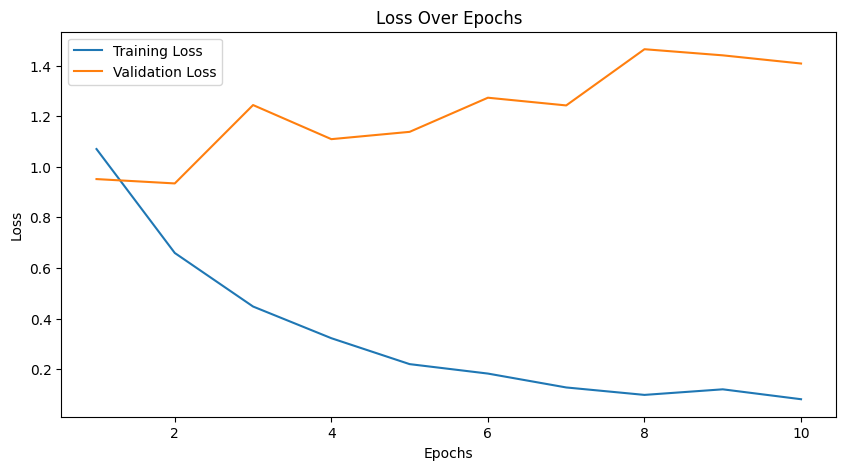

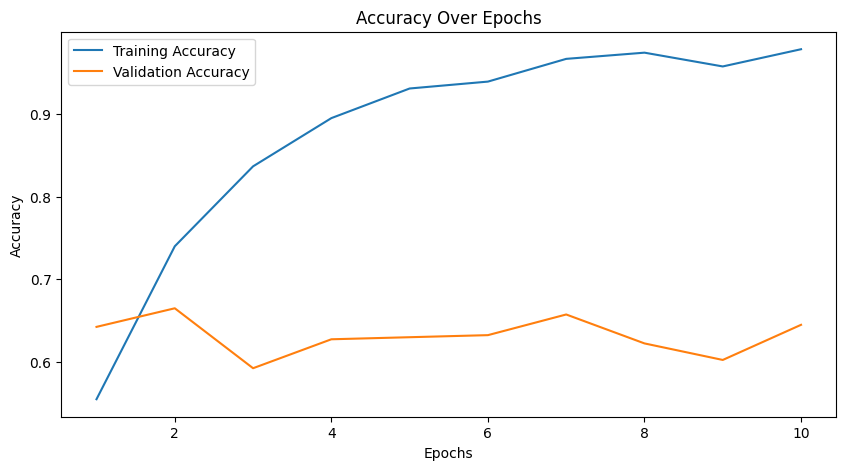

In [4]:


    # Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [11]:
  # Generate test predictions
save_test_predictions(model, test_loader, device)


Generating Test Predictions:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Generating Test Predictions: 100%|██████████| 13/13 [00:44<00:00,  3.44s/it]


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab Notebooks/dataset/content'

In [6]:
!pip install opencv-python
#import cv2 #

In [7]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=4d47884fe08f860e2a4bbdc3f898ac9ef9c852eb8fe28049396b227e84a1bf7a
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [8]:
import cv2
import matplotlib.pyplot as plt

def apply_gradcam(model, img_path, target_layer, output_path):
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform_test(image).unsqueeze(0).to(device)

    # Access layer4 through model.backbone
    cam = GradCAM(model=model, target_layers=[model.backbone.layer4[-1]])
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]

    # Resize grayscale_cam to match the image dimensions
    grayscale_cam = cv2.resize(grayscale_cam, (image.size[0], image.size[1]))

    visualization = show_cam_on_image(np.array(image) / 255.0, grayscale_cam, use_rgb=True)

    # Display the original image
    plt.figure() # Create a new figure
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()

    # Display the Grad-CAM visualization
    plt.figure() # Create another figure for Grad-CAM
    plt.imshow(visualization)
    plt.title("Grad-CAM Visualization")
    plt.show()

    # Save the visualization to the specified path
    plt.imsave(output_path, visualization)
    print(f"Grad-CAM visualization saved to: {output_path}")

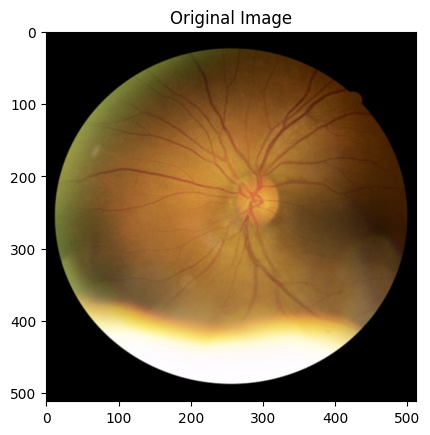

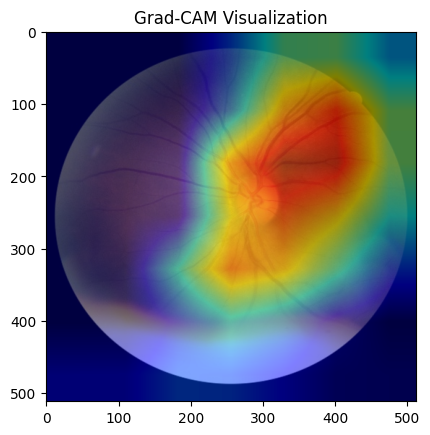

Grad-CAM visualization saved to: /content/drive/MyDrive/Colab Notebooks/dataset/gradcam_visualization_selfattention.jpg


In [10]:
import numpy as np
image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/release/DeepDRiD/val/402/402_l1.jpg'
output_path = '/content/drive/MyDrive/Colab Notebooks/dataset/gradcam_visualization_selfattention.jpg' # Choose your output path
apply_gradcam(model, image_path, target_layer=[model.backbone.layer4[-1]], output_path=output_path)